In [7]:
import os 
import sys
import random
import math
import numpy as np
import pandas as pd 
import glob 
import json
from matplotlib import pyplot as plt

import cv2
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm

In [8]:
DATA_DIR = '../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'stage_1_train_images')
TEST_DIR = os.path.join(DATA_DIR, 'stage_1_test_images')

MODEL_DIR = '../model/Mask_RCNN'
ORIG_SIZE = 1024

In [9]:
# Import Mask RCNN
sys.path.append(os.path.join(MODEL_DIR))  # To find local version of the library
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [10]:
from pneumonia import PneumoniaDataset2, PneumoniaConfig2
from functions import parse_dataset

In [11]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

config = PneumoniaConfig2()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [12]:
# Parse dataset
annotations = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels_2.csv'))
image_fps, image_annotations = parse_dataset(TRAIN_DIR, annotations)

In [13]:
# Split dataset into training vs. validation dataset
image_fps_train = pd.read_csv('image_fps_train.csv').image_fps_train.tolist()
image_fps_val = pd.read_csv('image_fps_val.csv').image_fps_val.tolist()
print('train_size=', len(image_fps_train))
print('validation_size=', len(image_fps_val))

train_size= 24184
validation_size= 1500


In [14]:
# Prepare the training dataset
dataset_train = PneumoniaDataset2(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Prepare the validation dataset
dataset_val = PneumoniaDataset2(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

In [15]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ])
])

In [16]:
# Build model
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)
MODEL_PATH = os.path.join(MODEL_DIR, 'pneumonia20181021T0214/mask_rcnn_pneumonia_0020.h5')

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(MODEL_PATH, by_name=True)

Re-starting from epoch 20


In [19]:
%%time
# Train model
LEARNING_RATE = 0.001

## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/50,
            epochs=22,
            layers='heads',
            augmentation=augmentation)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 20. LR=2e-05

Checkpoint Path: ../model/Mask_RCNN/pneumonia20181021T0214/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_

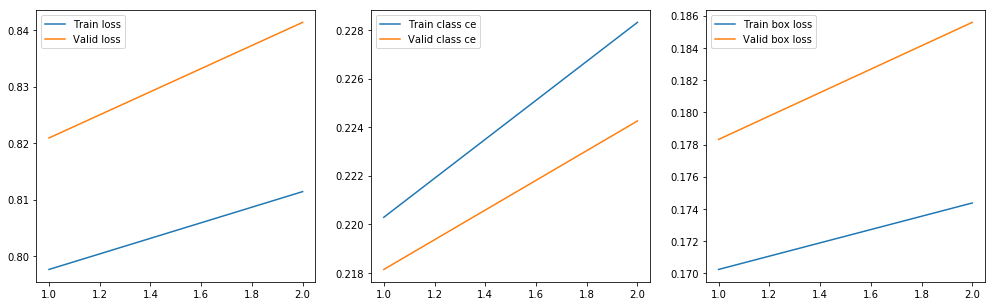

In [20]:
# Plot loss
epochs = range(1,len(next(iter(history.values())))+1)
df_history = pd.DataFrame(history, index=epochs)

plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [21]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1)

Best Epoch: 1


In [22]:
df_history

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,0.797655,0.170236,0.22029,0.250077,0.152728,0.004323,0.820932,0.178317,0.218144,0.234479,0.184846,0.005145
2,0.811432,0.174366,0.22831,0.251093,0.153394,0.004267,0.841396,0.185592,0.224252,0.239036,0.187501,0.005012


In [23]:
df_history.to_csv('df_history.csv', index=False)